In [393]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [394]:
data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

## DATA PROCESSING

In [395]:
# Calculate the mean of the "Age" column
mean_age = data['Age'].mean()
# Fill missing values in the "Age" column with the mean age
data['Age'].fillna(mean_age, inplace=True)
test_data['Age'].fillna(test_data['Age'].mean(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].mean(), inplace=True)
test_data=test_data.drop('Cabin',axis=1)
data = data.drop('Cabin', axis=1)
data = data.dropna()

In [397]:
training_X=data

In [398]:
training_y=training_X.pop('Survived')

In [399]:
train_X,val_X,train_y,val_y=train_test_split(training_X,training_y,test_size=0.2, random_state=42)

In [400]:
test_data.isna().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [401]:
train_X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,711.000000,711.000000,711.000000,711.000000,711.000000,711.000000
mean,446.922644,2.322082,29.863024,0.554149,0.382560,32.060354
std,256.635124,0.835180,13.122237,1.168643,0.804865,49.195227
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,225.500000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,451.000000,3.000000,29.699118,0.000000,0.000000,14.500000
75%,672.500000,3.000000,36.000000,1.000000,0.000000,30.695800
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [402]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 711 entries, 708 to 103
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  711 non-null    int64  
 1   Pclass       711 non-null    int64  
 2   Name         711 non-null    object 
 3   Sex          711 non-null    object 
 4   Age          711 non-null    float64
 5   SibSp        711 non-null    int64  
 6   Parch        711 non-null    int64  
 7   Ticket       711 non-null    object 
 8   Fare         711 non-null    float64
 9   Embarked     711 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 61.1+ KB


In [403]:
train_X.shape

(711, 10)

In [404]:
train_y

708    1
240    0
382    0
792    0
683    0
      ..
107    1
271    1
862    1
436    0
103    0
Name: Survived, Length: 711, dtype: int64

## DATA EXPLORATION

<AxesSubplot:>

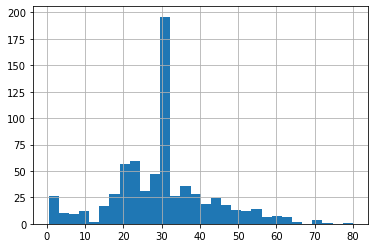

In [405]:
train_X.Age.hist(bins=30)

<AxesSubplot:ylabel='Sex'>

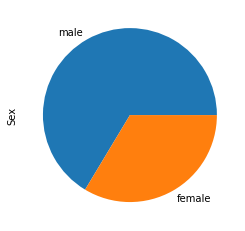

In [406]:
train_X.Sex.value_counts().plot(kind='pie')

<AxesSubplot:>

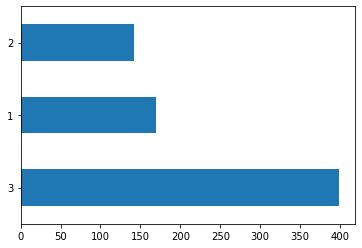

In [407]:
train_X.Pclass.value_counts().plot(kind='barh')

<AxesSubplot:ylabel='Sex'>

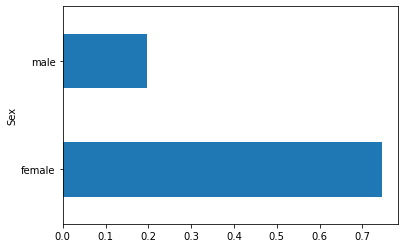

In [408]:
pd.concat([train_X,train_y],axis=1).groupby('Sex').Survived.mean().plot(kind='barh')

## FEATURE COLUMN 

In [410]:
train_y=pd.DataFrame(train_y)

In [411]:
train_y

,Survived
708,1
240,0
382,0
792,0
683,0
...,...
107,1
271,1
862,1
436,0


In [412]:
categorical_columns=['Pclass','Sex','SibSp','Parch','Embarked']
numerical_columns=['Fare','Age']

In [413]:
features_columns=[]
for feature_name in categorical_columns:
    vocabulary=train_X[feature_name].unique()
    features_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name,vocabulary))

for feature_name in numerical_columns:
    features_columns.append(tf.feature_column.numeric_column(feature_name,dtype=tf.float32))

In [414]:
features_columns

[VocabularyListCategoricalColumn(key='Pclass', vocabulary_list=(1, 3, 2), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='Sex', vocabulary_list=('female', 'male'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='SibSp', vocabulary_list=(0, 1, 8, 5, 4, 2, 3), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='Parch', vocabulary_list=(0, 2, 1, 3, 6, 4, 5), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='Embarked', vocabulary_list=('S', 'C', 'Q'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 NumericColumn(key='Fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='Age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

## TESNOR FLOW DATA INPUT

In [415]:
def make_input_fn(data_df, label_df, num_epochs=None, shuffle=True, batch_size=32):
    def input_fn():
        # Create a TensorFlow Dataset from your data and labels
        dataset = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        
        # Shuffle and repeat the dataset if needed
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(data_df))
        if num_epochs is not None:
            dataset = dataset.repeat(num_epochs)
        
        # Batch the dataset
        dataset = dataset.batch(batch_size)
        
        return dataset
    
    return input_fn

# Example usage:
train_input_fn = make_input_fn(train_X, train_y, num_epochs=15)
val_input_fn=make_input_fn(val_X,val_y,1,False)

In [416]:
train_input

<function __main__.make_input_fn.<locals>.input_fn()>

## TRAINING AND EVALUTION

In [417]:
linear_est=tf.estimator.LinearClassifier(feature_columns=features_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\ALIHAI~1\\AppData\\Local\\Temp\\tmp97yriltw', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [418]:
linear_est.train(train_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\ALIHAI~1\AppData\Local\Temp\tmp97yriltw\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 391.065
INFO:tensorflow:loss = 0.47030425, step = 100 (0.256 sec)
INFO:tensorflow:global_step/sec: 834.442
INFO:tensorflow:loss = 0.3827455, step = 200 (0.124 sec)
INFO:tensorflow:global_step/sec: 1000.97
INFO:tensorflow:loss = 0.490285, step = 300 (0.096 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 334...
INFO:tensorflow:Saving checkpoints for 334 into C:\Users\ALIHAI~1\AppData\Local\Temp\tmp97yri

In [426]:
linear_est.evaluate(val_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-09-05T16:20:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\ALIHAI~1\AppData\Local\Temp\tmp97yriltw\model.ckpt-334
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.57755s
INFO:tensorflow:Finished evaluation at 2023-09-05-16:20:49
INFO:tensorflow:Saving dict for global step 334: accuracy = 0.8146067, accuracy_baseline = 0.6123595, auc = 0.85214734, auc_precision_recall = 0.79605246, average_loss = 0.4539575, global_step = 334, label/mean = 0.38764045, loss = 0.48235846, precision = 0.7647059, prediction/mean = 0.41247293, recall = 0.7536232
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 334: C:\Users\ALIHAI~1\AppData\Local\Temp\tmp97yriltw\model.ckpt-334


{'accuracy': 0.8146067,
 'accuracy_baseline': 0.6123595,
 'auc': 0.85214734,
 'auc_precision_recall': 0.79605246,
 'average_loss': 0.4539575,
 'label/mean': 0.38764045,
 'loss': 0.48235846,
 'precision': 0.7647059,
 'prediction/mean': 0.41247293,
 'recall': 0.7536232,
 'global_step': 334}

In [427]:
results=list(linear_est.predict(val_input_fn))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\ALIHAI~1\AppData\Local\Temp\tmp97yriltw\model.ckpt-334
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [433]:
print(val_X.iloc[0])
print(val_y.iloc[0])

PassengerId                                 282
Pclass                                        3
Name           Olsson, Mr. Nils Johan Goransson
Sex                                        male
Age                                        28.0
SibSp                                         0
Parch                                         0
Ticket                                   347464
Fare                                     7.8542
Embarked                                      S
Name: 281, dtype: object
0


In [436]:
results[0]

{'logits': array([-2.4772666], dtype=float32),
 'logistic': array([0.07746732], dtype=float32),
 'probabilities': array([0.9225327 , 0.07746732], dtype=float32),
 'class_ids': array([0], dtype=int64),
 'classes': array([b'0'], dtype=object),
 'all_class_ids': array([0, 1]),
 'all_classes': array([b'0', b'1'], dtype=object)}

In [435]:
results[0]['probabilities'][1]

0.07746732

## PREDICTION

In [440]:
def predict_survival(test_data, model):

    # Make predictions using the trained model
    input_fn = make_input_fn(test_data,label_df=None,  shuffle=False, batch_size=1)
    predictions = list(model.predict(input_fn=input_fn))
    
    # Extract the predicted class labels (0 or 1) from the predictions
    predicted_labels = [prediction['class_ids'][0] for prediction in predictions]
    
    return predicted_labels

predictions = predict_survival(test_data, linear_est)
print(predictions)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\ALIHAI~1\AppData\Local\Temp\tmp97yriltw\model.ckpt-334
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0

In [445]:
result_df = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': predictions})


In [447]:
result_df.to_csv("submission.csv", header=True, index=False)